# Industrial Process Metrics Forecasting

targets: `consumoEspecificoTG2_2`, `consumoEspecificoTG2_1`, `consumoEspecificoTG1_2`, `consumoEspecificoTG1_1`


## Goals

- Develop an empirical model of the industrial process using AI.
- Achieve millisecond response times for the model.
- Ensure a maximum error of 0.2% compared to the digital twin.

In [1]:
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X_train = pd.read_csv('data/processed/X_train.csv')
y_train = pd.read_csv('data/processed/y_train.csv')
X_val = pd.read_csv('data/processed/X_val.csv')
y_val = pd.read_csv('data/processed/y_val.csv')
X_test = pd.read_csv('data/processed/X_test.csv')
y_test = pd.read_csv('data/processed/y_test.csv')

In [3]:
features = ['vazaoVapor', 'pressaoVapor', 'temperaturaVapor',
            'cargaVaporTG1', 'cargaVaporTG2', 'habilitaTG1', 'habilitaTG2']

In [4]:
targets = ['consumoEspecificoTG1_1', 'consumoEspecificoTG1_2',
           'consumoEspecificoTG2_1', 'consumoEspecificoTG2_2',
           'potenciaGeradaTG1_1', 'potenciaGeradaTG1_2',
           'potenciaGeradaTG2_1', 'potenciaGeradaTG2_2',
           'vazaoVaporEscape']

In [5]:
target_zeros_count = (y_train == 0).sum()
target_zeros_count

consumoEspecificoTG1_1    129630
consumoEspecificoTG1_2    129630
consumoEspecificoTG2_1    131166
consumoEspecificoTG2_2    131166
potenciaGeradaTG1_1       129630
potenciaGeradaTG1_2       129630
potenciaGeradaTG2_1       131166
potenciaGeradaTG2_2       131166
vazaoVaporEscape               0
dtype: int64

In [6]:
# Percentage of zeros in the target
target_zeros_count / y_train.shape[0]

consumoEspecificoTG1_1    0.500228
consumoEspecificoTG1_2    0.500228
consumoEspecificoTG2_1    0.506155
consumoEspecificoTG2_2    0.506155
potenciaGeradaTG1_1       0.500228
potenciaGeradaTG1_2       0.500228
potenciaGeradaTG2_1       0.506155
potenciaGeradaTG2_2       0.506155
vazaoVaporEscape          0.000000
dtype: float64

In [7]:
columns_with_zeros = target_zeros_count[target_zeros_count > 0].index

## Creating neural network

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.models import load_model

In [9]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

In [49]:
class Model:
    def __init__(self, X_train, y_train, X_val, y_val):
        self.X_train = X_train
        self.X_train_scaled = None
        self.y_train = y_train
        self.X_val = X_val
        self.X_val_scaled = None
        self.y_val = y_val
        self.model = None
        self.history = None
        self.scaler = None

    def create_model(self):
        model = Sequential()
        model.add(Input(shape=(self.X_train.shape[1],)))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(self.y_train.shape[1], activation='linear'))
        model.compile(optimizer='adam', loss='mse')
        self.model = model


    def add_callbacks(self, callbacks: list):
        if not isinstance(callbacks, list) or len(callbacks) == 0:
            raise ValueError('callbacks must be a list with at least one callback')
        self.callbacks = callbacks
            
    def train(self, epochs=100, batch_size=32):
        if not self.model:
            self.create_model()

        if not self.scaler:
            self.scaler = StandardScaler()
        if not self.X_train_scaled:
            self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        if not self.X_val_scaled:
            self.X_val_scaled = self.scaler.transform(self.X_val)

        self.history = self.model.fit(self.X_train_scaled, self.y_train,
                                      epochs=epochs, batch_size=batch_size,
                                      validation_data=(self.X_val_scaled, self.y_val),
                                      verbose=1,
                                      callbacks=self.callbacks)

    def plot_loss(self):
        plt.plot(self.history.history['loss'], label='train')
        plt.plot(self.history.history['val_loss'], label='validation')
        plt.legend()
        plt.show()

    def save(self, path):
        self.model.save(path)

    def load(self, path):
        self.model = load_model(path)

    def predict(self, X):
        return self.model.predict(X)
    
    def evaluate(self, X, y):
        return self.model.evaluate(X, y)

In [50]:
model = Model(X_train, y_train, X_val, y_val)

In [10]:
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint_cb = ModelCheckpoint('./models/dense_64_32_11_mse_v1.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [52]:
model.add_callbacks([early_stopping_cb, model_checkpoint_cb])

In [53]:
boolean_columns = ['habilitaTG1', 'habilitaTG2']
low_cardinality_columns = [col for col in X_train.columns if X_train[col].nunique() < 15 and col not in boolean_columns]
low_cardinality_columns

[]

In [54]:
model.train(epochs=1000, batch_size=32)

Epoch 1/1000
8067/8099 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 1184.5944
Epoch 1: val_loss improved from inf to 242904992.00000, saving model to ./models/dense_64_32_11_mse_v1.keras
8099/8099 ━━━━━━━━━━━━━━━━━━━━ 6s 611us/step - loss: 1180.8561 - val_loss: 242904992.0000
Epoch 2/1000
8085/8099 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 24.9464
Epoch 2: val_loss improved from 242904992.00000 to 217380816.00000, saving model to ./models/dense_64_32_11_mse_v1.keras
8099/8099 ━━━━━━━━━━━━━━━━━━━━ 5s 606us/step - loss: 24.9443 - val_loss: 217380816.0000
Epoch 3/1000
8063/8099 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 17.2966
Epoch 3: val_loss improved from 217380816.00000 to 202092784.00000, saving model to ./models/dense_64_32_11_mse_v1.keras
8099/8099 ━━━━━━━━━━━━━━━━━━━━ 5s 602us/step - loss: 17.3135 - val_loss: 202092784.0000
Epoch 4/1000
8030/8099 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 27.7722
Epoch 4: val_loss improved from 202092784.00000 to 199964912.00000, saving model to .

KeyboardInterrupt: 

In [10]:
new_train = False
model_name = 'dense_64_32_11_mse_v1.1.keras'

try:
    if new_train:
        raise Exception('Forçando novo treinamento')
    model = load_model(f'./models/{model_name}')
    print('Pre-trained model loaded successfully')
except Exception as e:
    print('Could not load model:', e.__repr__())
    model = Sequential()

    model.add(Input(shape=(len(features),)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(targets)))

    model.compile(optimizer='adam', loss='mean_squared_error')

Pre-trained model loaded successfully


In [11]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,669 (33.87 KB)

 Trainable params: 2,889 (11.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,780 (22.58 KB)

In [20]:
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint_cb = ModelCheckpoint(f'./models/{model_name}', monitor='val_loss', save_best_only=True, verbose=1)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [22]:
if new_train:
    # Set model train seed
    set_random_seed(42)

    history = model.fit(X_train_scaled, y_train, epochs=1000, validation_data=(X_val_scaled, y_val), callbacks=[early_stopping_cb, model_checkpoint_cb])

Epoch 1/1000
8091/8099 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1816.7032
Epoch 1: val_loss improved from inf to 32.20903, saving model to ./models/dense_64_32_11_mse_v1.2.keras
8099/8099 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 1815.1715 - val_loss: 32.2090
Epoch 2/1000
   1/8099 ━━━━━━━━━━━━━━━━━━━━ 7:03 52ms/step - loss: 4.5487

: 

In [12]:
def symetric_mape(A, F):
    """
    Symmetric Mean Absolute Percentage Error (SMAPE) metric.

    Parameters
    ----------
    A : np.array
        Actual values.

    F : np.array
        Forecasted values.

    Returns
    -------
    float
        SMAPE metric value.
    
    """
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [20]:
def shifted_mape(A, F):
    """
    Shifted Mean Absolute Percentage Error (MAPE) metric to avoid division by zero.

    Parameters
    ----------
    A : np.array
        Actual values.

    F : np.array
        Forecasted values.

    Returns
    -------
    float
        Shifted MAPE metric value.
    
    """
    return 100/len(A) * np.sum(np.abs(F+1 - A+1) / np.abs(A+1))

### Reference values for MAPE and SMAPE

| MAPE Value | SMAPE Value | Predictive Performance Evaluation
| :-: | :-: | :-: |
| < 10% | <10% | Highly accurate forecasting |
| 10-20% | 10-20% | Good forecasting |
| 20-50% | 20-50% | Reasonable forecasting |
| >50% | >50% | Inaccurate forecasting |


In [13]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [ ]:
y_pred = model.predict(X_test_scaled)

In [25]:
print('Overall metrics:')
print('R2:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print('Shifted MAPE:', np.mean(shifted_mape(y_test, y_pred)))
print('Symetric MAPE:', np.mean(symetric_mape(y_test, y_pred)))
print('MSE:', np.mean((y_test - y_pred)**2))

Overall metrics:
R2: 0.9888539353325039
MAPE: 291199363057691.75
Shifted MAPE: 98.90440482156157
Symetric MAPE: 91.05149566642595
MSE: 2.355554849131088


c:\Users\lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [21]:


smape = np.array([symetric_mape(y_test[target], y_pred[:, i]) for i, target in enumerate(targets)])
mape = np.array([mean_absolute_percentage_error(y_test[target], y_pred[:, i]) for i, target in enumerate(targets)])
shif_mape = np.array([shifted_mape(y_test[target], y_pred[:, i]) for i, target in enumerate(targets)])
r_2 = np.array([r2_score(y_test[target], y_pred[:, i]) for i, target in enumerate(targets)])
mse = np.array([np.mean((y_test[target] - y_pred[:, i])**2) for i, target in enumerate(targets)])

# Create a DataFrame with the MAPE for each target
mape_df = pd.DataFrame({'mape': mape, 'smape': smape, 'shifted mape': shif_mape, 'r2': r_2, 'mse': mse}, index=targets).sort_values('mse')
mape_df

450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,mape,smape,shifted mape,r2,mse
consumoEspecificoTG1_2,1.486349e+14,100.244385,109.835402,0.999116,0.020197
consumoEspecificoTG2_2,1.904107e+14,102.186390,106.638037,0.999338,0.022514
potenciaGeradaTG2_2,2.479268e+14,104.263931,116.456995,0.996233,0.034226
consumoEspecificoTG2_1,2.170767e+14,103.214952,116.922971,0.990021,0.078247
potenciaGeradaTG1_2,3.259803e+14,100.168433,109.688993,0.999210,0.080970
potenciaGeradaTG2_1,3.418321e+14,103.122653,114.356227,0.998415,0.131863
potenciaGeradaTG1_1,5.135414e+14,101.295703,105.145200,0.998763,0.190267
vazaoVaporEscape,4.732285e-03,0.471885,1.035810,0.998949,5.067501
consumoEspecificoTG1_1,6.353914e+14,104.495129,110.060008,0.919640,15.574207


450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


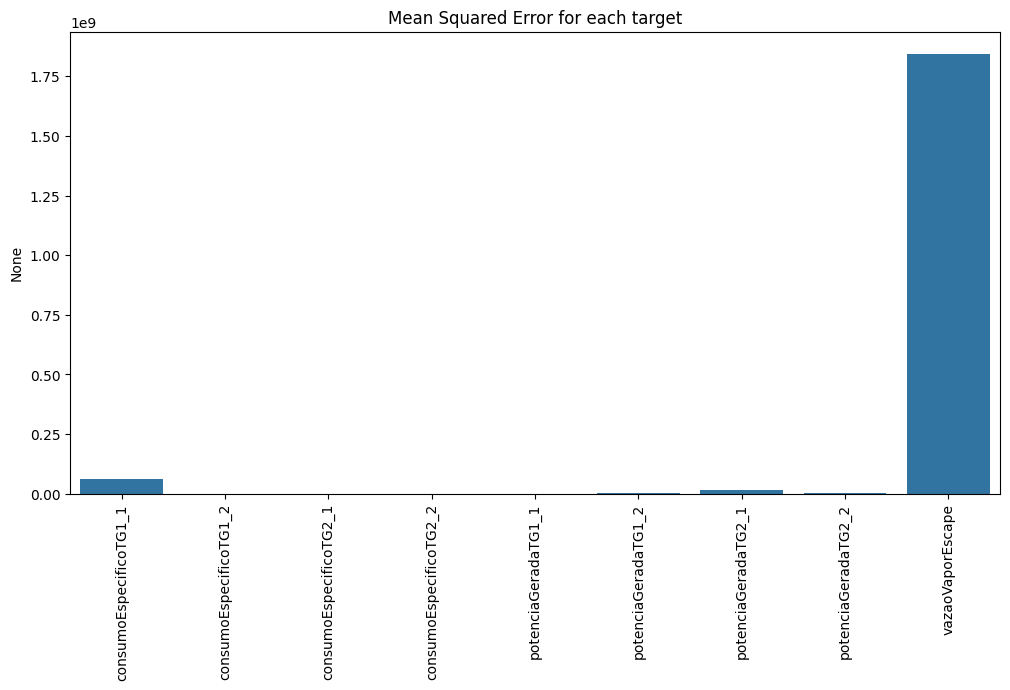

In [17]:
# Predicting the test set
y_pred = model.predict(X_test)

# Calculating the mean squared error for each target
mse = np.mean((y_test - y_pred) ** 2, axis=0)

# Plotting the mean squared error for each target
plt.figure(figsize=(12, 6))
sns.barplot(x=targets, y=mse)
plt.xticks(rotation=90)
plt.title('Mean Squared Error for each target')
plt.show()


  1/456 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step

456/456 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step


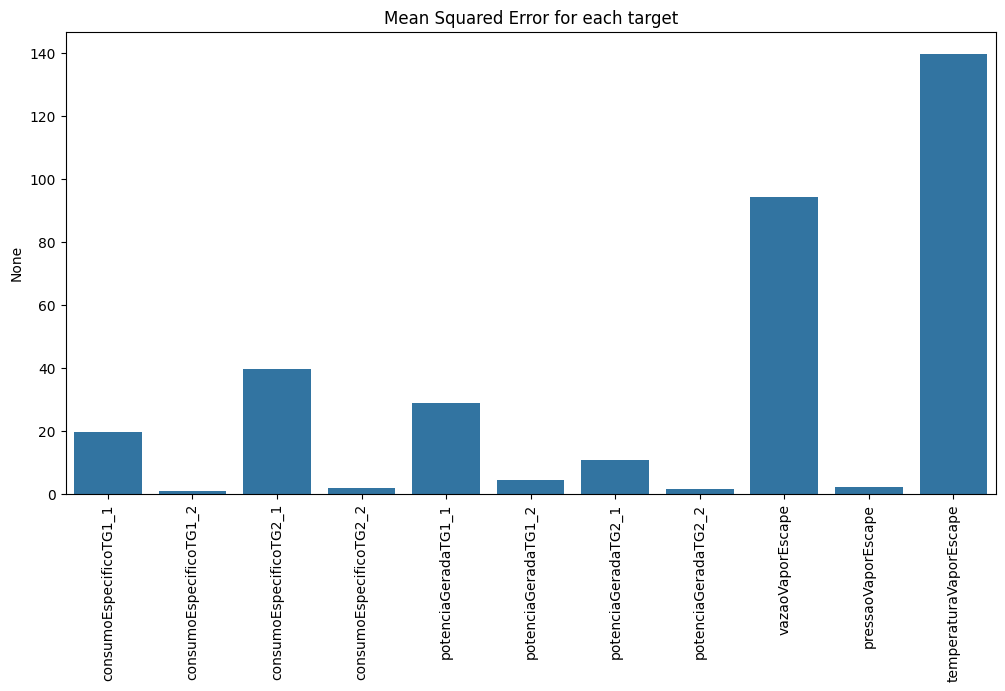

In [92]:
# Predicting the test set
y_pred = model.predict(X_test)

# Calculating the mean squared error for each target
mse = np.mean((y_test - y_pred) ** 2, axis=0)

# Plotting the mean squared error for each target
plt.figure(figsize=(12, 6))
sns.barplot(x=targets, y=mse)
plt.xticks(rotation=90)
plt.title('Mean Squared Error for each target')
plt.show()
